# Evaluate and submit predictions

### Imports

In [1]:
import os
if 'notebooks' in os.getcwd(): os.chdir('../..')  # change to main directory
print('Working directory:', os.getcwd() )

Working directory: /scratch/snx3000/bp000429/submission/adrian_sensorium


In [2]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from nnfabrik.builder import get_data, get_model, get_trainer

from sensorium.utility import submission
from sensorium.utility.training import read_config

### Load configuration for model

In [3]:
config_file = 'notebooks/submission/config_submission_m2.yaml'
config = read_config( config_file )
print(config)

ordereddict([('data_sets', ['all']), ('dataset_fn', 'sensorium.datasets.static_loaders'), ('dataset_config', ordereddict([('normalize', True), ('include_behavior', True), ('include_eye_position', True), ('batch_size', 128), ('scale', 0.25), ('preload_from_merged_data', True), ('include_trial_id', True), ('include_rank_id', True), ('include_history', True), ('include_behav_state', True), ('adjusted_normalization', True)])), ('model_fn', 'sensorium.models.modulated_stacked_core_full_gauss_readout'), ('model_seed', 3452), ('model_config', ordereddict([('pad_input', False), ('stack', -1), ('layers', 4), ('input_kern', 9), ('gamma_input', 6.3831), ('gamma_readout', 0.0076), ('hidden_kern', 7), ('hidden_channels', 64), ('depth_separable', True), ('grid_mean_predictor', ordereddict([('type', 'cortex'), ('input_dimensions', 2), ('hidden_layers', 4), ('hidden_features', 20), ('nonlinearity', 'ReLU'), ('final_tanh', True)])), ('init_sigma', 0.1), ('init_mu_range', 0.3), ('gauss_type', 'full'), (

### Prepare dataloader

In [4]:
if config['data_sets'][0] == 'all':
    basepath = "notebooks/data/"
    filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
    filenames = [file for file in filenames if 'static26872-17-20' not in file]
else:
    filenames = config['data_sets']
    # filenames like ['notebooks/data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', ]
    
dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
dataset_config = {'paths': filenames,
                  **config['dataset_config'],
                 }

dataloaders = get_data(dataset_fn, dataset_config)

### Load saved model

In [5]:
# Instantiate model
model_fn = config['model_fn']     # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
model_config = config['model_config']

model = get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders,
                  seed=config['model_seed'],
                 )

# Load trained weights
save_file = 'notebooks/submission/results/model_v2.pth'
model.load_state_dict(torch.load(save_file));

### Generate submission file

In [6]:
dataset_name = '27204-5-13'

submission.generate_submission_file(trained_model=model, 
                                    dataloaders=dataloaders,
                                    data_key=dataset_name,
                                    path="notebooks/submission/results/",
                                    device="cuda")

Submission file saved for tier: live_test. Saved in: notebooks/submission/results/submission_file_live_test.csv
Submission file saved for tier: final_test. Saved in: notebooks/submission/results/submission_file_final_test.csv


### Evaluate model on all datasets

In [7]:
from sensorium.utility import get_correlations, get_signal_correlations, get_fev
from sensorium.utility.measure_helpers import get_df_for_scores

#### Test data

In [8]:
single_trial_correlation = get_correlations(model, dataloaders, tier="test", device="cuda", as_dict=True)

df = get_df_for_scores(session_dict=single_trial_correlation,
                                    measure_attribute="Single Trial Correlation"
                      )

In [9]:
%matplotlib inline

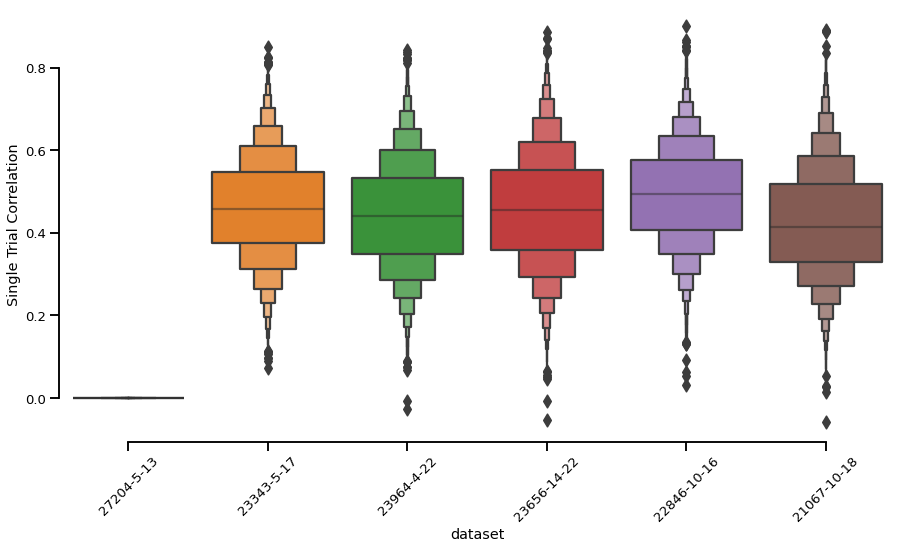

In [10]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation = 45);
sns.despine(trim=True)

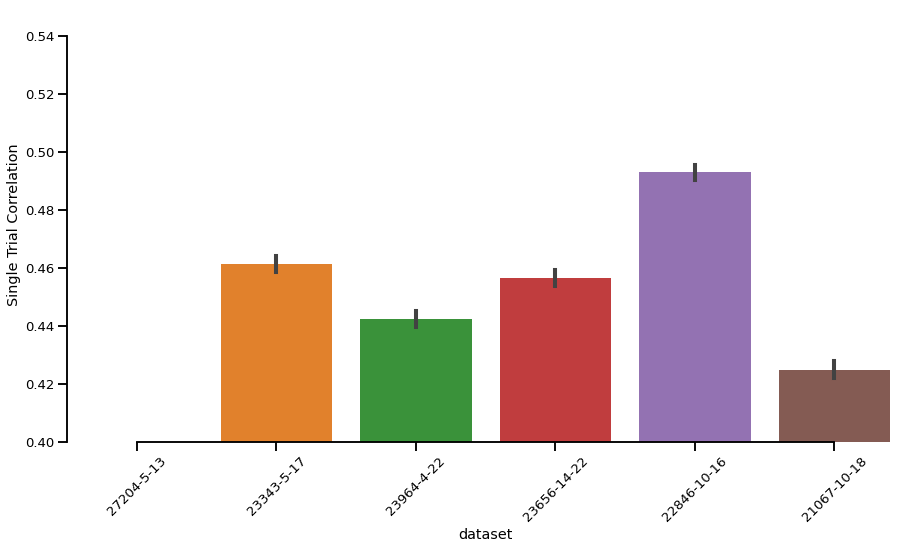

In [11]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15,8))
sns.barplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation = 45);
plt.ylim(0.4,0.55)
sns.despine(trim=True)

In [12]:
df.groupby('dataset').describe()

Single Trial Correlation                                          \
                               count      mean       std       min       25%   
dataset                                                                        
21067-10-18                   8372.0  0.424852  0.134864 -0.057482  0.329783   
22846-10-16                   7344.0  0.492947  0.122445  0.032551  0.407868   
23343-5-17                    7334.0  0.461147  0.126429  0.072625  0.374945   
23656-14-22                   8107.0  0.456466  0.139856 -0.052058  0.358064   
23964-4-22                    8098.0  0.442301  0.132478 -0.026214  0.349343   
27204-5-13                    7538.0  0.000000  0.000000  0.000000  0.000000   

                                           
                  50%       75%       max  
dataset                                    
21067-10-18  0.414433  0.518269  0.890321  
22846-10-16  0.494640  0.577064  0.899864  
23343-5-17   0.458964  0.546255  0.850283  
23656-14-22  0.454712  0.552048  0.887266  
23964-4-22   0.440197  0.532599  0.844007  
27204-5-13   0.000000  0.000000  0.000000

#### Validation data

In [13]:
single_trial_correlation = get_correlations(model, dataloaders, tier="validation", device="cuda", as_dict=True)

df = get_df_for_scores(session_dict=single_trial_correlation,
                                    measure_attribute="Single Trial Correlation"
                      )

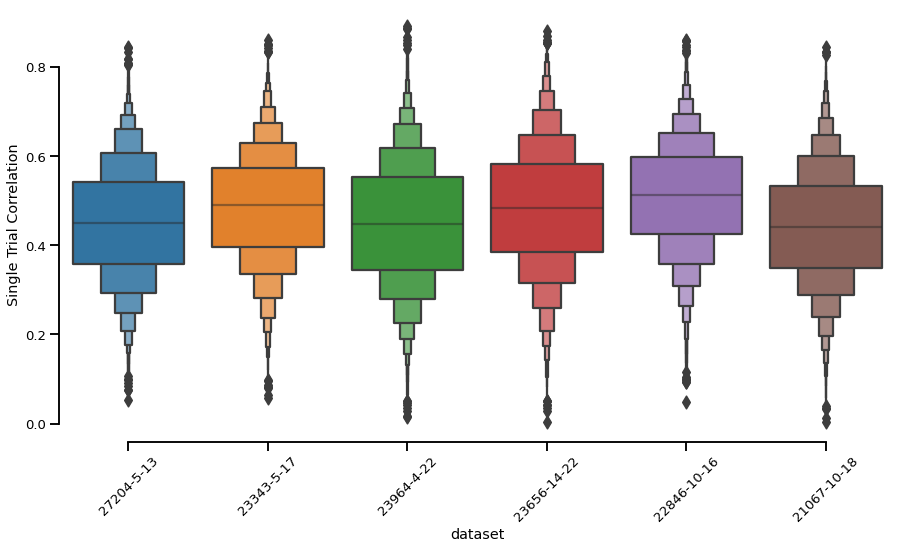

In [14]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation = 45);
sns.despine(trim=True)

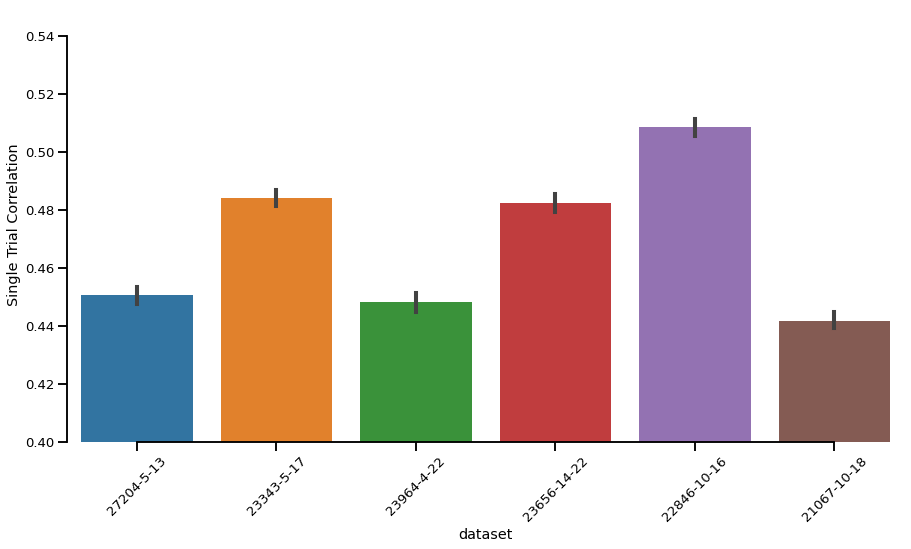

In [15]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15,8))
sns.barplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation = 45);
plt.ylim(0.4,0.55)
sns.despine(trim=True)

In [16]:
df.groupby('dataset').describe()

Single Trial Correlation                                          \
                               count      mean       std       min       25%   
dataset                                                                        
21067-10-18                   8372.0  0.441715  0.132310  0.003877  0.349123   
22846-10-16                   7344.0  0.508420  0.126056  0.049031  0.424635   
23343-5-17                    7334.0  0.484139  0.127134  0.057682  0.396292   
23656-14-22                   8107.0  0.482365  0.143426  0.004163  0.384418   
23964-4-22                    8098.0  0.448009  0.142889  0.014536  0.344831   
27204-5-13                    7538.0  0.450419  0.131745  0.053065  0.357068   

                                           
                  50%       75%       max  
dataset                                    
21067-10-18  0.441494  0.533822  0.844561  
22846-10-16  0.513304  0.596912  0.860942  
23343-5-17   0.490203  0.573285  0.861078  
23656-14-22  0.484011  0.582004  0.879854  
23964-4-22   0.446884  0.552537  0.890933  
27204-5-13   0.449042  0.542634  0.844241